# A prismatic cantilever beam under a tip load

This is an example of the geometrically-exact beam structural solver in SHARPy. It is the simplest possible beam, with isotropic properties and deformations in the x-z plane, but including geometrically-nonlinear effects in its static equilibrium. The example includes two problems: 1) static equilibrium under a (large) dead load applied at the tip, which can be benchmarked against the literature (see the reference below); 2) a comparison between dead and follower force effects. Both cases are included in example 8.1 in [Palacios & Cesnik's book](https://doi.org/10.1017/9781108354868).

It runs with [SHARPy](www.imperial.ac.uk/aeroelastics/sharpy) v2.4.

Original reference:
Simpson R.J.S., Palacios R., “Numerical Aspects of Nonlinear Flexible Aircraft Flight Dynamics Modeling.” 54th AIAA/ASME/ASCE/AHS/ASC Structures, Structural Dynamics and Materials Conference, 8-11 April 2013, Boston, Massachusetts, USA [http://hdl.handle.net/10044/1/11077, http://dx.doi.org/10.2514/6.2013-1634]

Latest update: 30.03.2025

## Required Packages
Import some python packages, SHARPy, and the python script with model definition (this one needs to be in the local folder).  

In [56]:
import numpy as np
import os
import matplotlib.pyplot as plt
import sharpy.sharpy_main           # to run SHARPy from Jupyter
import cantilever.model as model    # model definition
from IPython.display import Image   # to import images.

plt.rcParams.update({'font.size': 20})   # Large fonts in all plots

## Problem 1: Tip vertical dead load
Consider first a massless beam with a heavy tip mass, such that the deformations are due to the resulting dead load P. The static equilibrium will be obtained for multiple values of P=0, 100, ..., 1000 kN

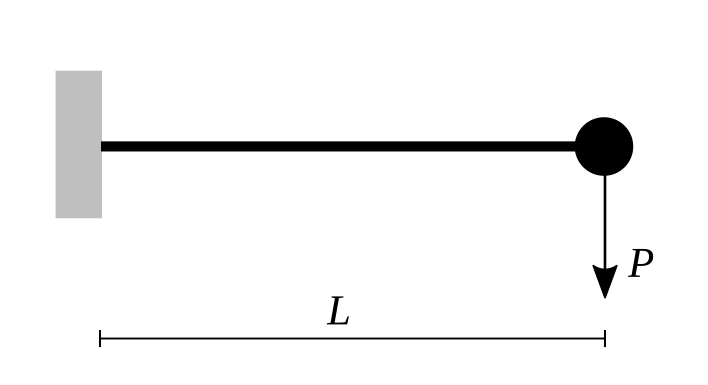

In [57]:
Image('images/cantilever.png', width=500)

In [ ]:
# Define temporary files to generate sharpy models
route = 'cantilever/'
case_name= 'temp'

# Define values of the tip forces up to P=Nforces*DeltaForce
Nforces=10         # Number of force steps
DeltaForce=100e3   # Increment of forces

# Discretization of the straight beam. It uses 3-noded elements of equal length
Nelem=20           # Number of beam elements
N=2*Nelem+1        # Number of grid nodes

# Inialize the x-z nodal coordinates of the deformed beam for each force step 
x1=np.zeros((Nforces,N))
z1=np.zeros((Nforces,N))

# Loop through all external forces
for jForce in range(Nforces):
    # Call the functions that generate the model and define the simulation options. 
    model.clean_test_files(route, case_name)
    model.generate_fem_file(route, case_name, Nelem, float(jForce+1)*DeltaForce)
    model.generate_solver_file(route, case_name, ['BeamLoader', 'NonLinearStatic'])

    # Run SHARPy and store the x-z coordinates for the current load
    case_data=sharpy.sharpy_main.main(['', route + case_name + '.sharpy'])

    x1[jForce,0:N]=case_data.structure.timestep_info[0].pos[:, 0]
    z1[jForce,0:N]=case_data.structure.timestep_info[0].pos[:, 2]

# Store finally the initial geometry (only once)
x0=case_data.structure.ini_info.pos[:, 0]
z0=case_data.structure.ini_info.pos[:, 2]

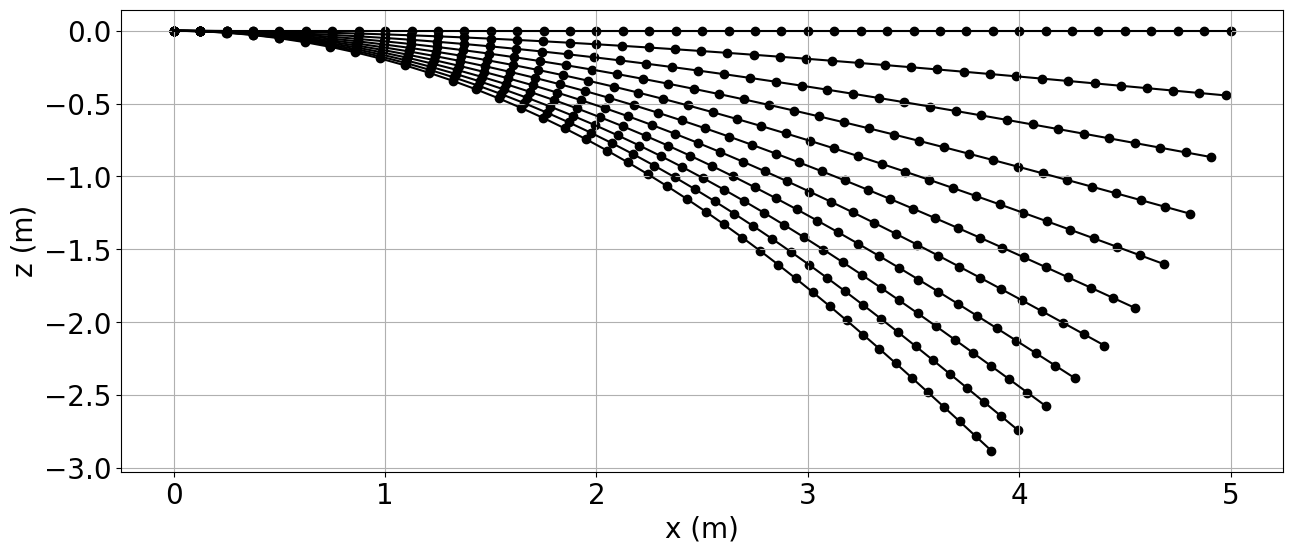

In [59]:
# Plot the deformed beam shapes for all force steps (Figure 8.1 in Palacios & Cesnik's book)
fig= plt.subplots(1, 1, figsize=(15, 6))

# Plot undeformed shape
plt.scatter(x0,z0,c='black')
plt.plot(x0,z0,c='black')

# Plot deformed shapes
for jForce in range(Nforces):
    plt.scatter(x1[jForce,0:N],z1[jForce,0:N],c='black')
    plt.plot(x1[jForce,0:N],z1[jForce,0:N],c='black')

# Include labels and store.
plt.grid('equal')
plt.xlabel('x (m)')
plt.ylabel('z (m)')
plt.savefig("images/ncb1-dead-displ.eps",  format='eps', dpi=1000, bbox_inches='tight')

In [60]:
# Display numerical values of the vertical position of the free end.
print('{:>8s}{:>12s}'.format('Force (N)','Tip z (m)'))
dash=20*'-'; print(dash)
for jForce in range(Nforces):
    print('{:>8.0f}{:>12.3f}'.format((jForce+1)*DeltaForce,z1[jForce,N-1]))

Force (N)   Tip z (m)
--------------------
  100000      -0.444
  200000      -0.867
  300000      -1.255
  400000      -1.600
  500000      -1.900
  600000      -2.160
  700000      -2.382
  800000      -2.574
  900000      -2.739
 1000000      -2.881


In [61]:
# Remove temporary files.
model.clean_test_files(route, case_name)

## Problem 2: Comparing follower and dead forces
Same problem as before, but now we also include the case where the tip force remains normal to the beam as it deformes (the *follower force* problem).

In [ ]:
# Initialize the variables to store the coordinates for all the new load cases
x2=np.zeros((Nforces,N))
z2=np.zeros((Nforces,N))

# Loop through all load steps for the follower force problem
for jForce in range(Nforces):
    model.clean_test_files(route, case_name)
    model.generate_fem_file(route, case_name, Nelem, 0, -float(jForce+1)*DeltaForce)
    model.generate_solver_file(route,case_name, ['BeamLoader', 'NonLinearStatic'])

    case_foll=sharpy.sharpy_main.main(['', route + case_name + '.sharpy'])

    # Store the x-z coordinates
    x2[jForce,0:N]=case_foll.structure.timestep_info[0].pos[:, 0]
    z2[jForce,0:N]=case_foll.structure.timestep_info[0].pos[:, 2]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


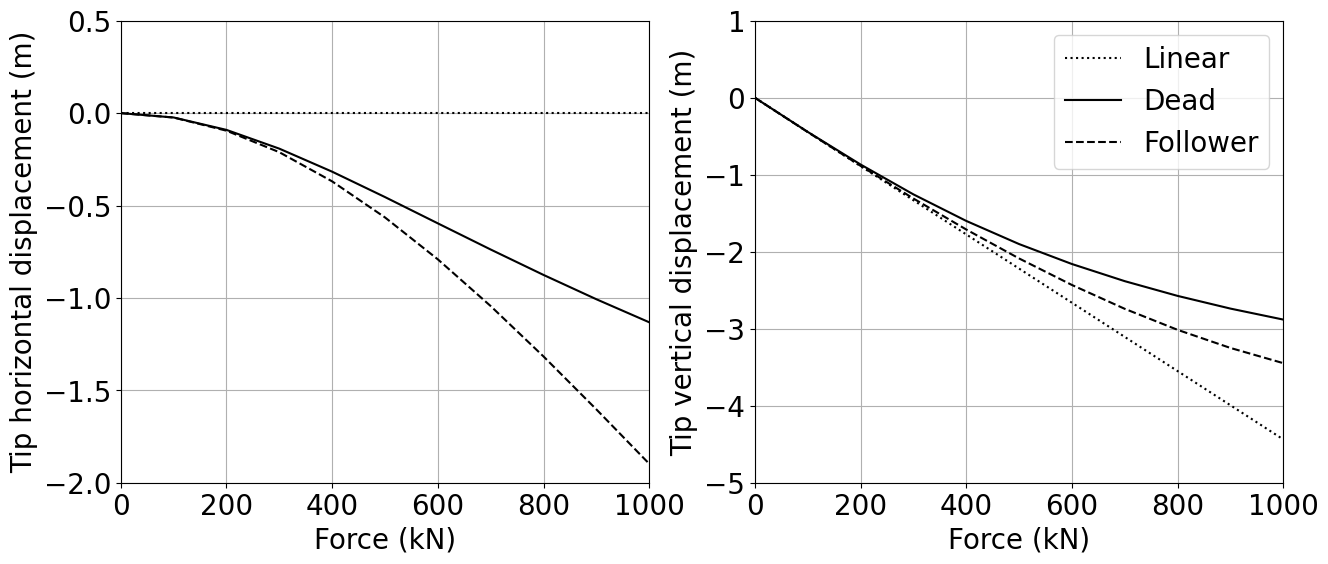

In [63]:
# Plotting the results (figure 8.8 in Palacios & Cesnik's book)

# Generate two subfigures.
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Write all force steps in kN.
RangeForces=np.arange(0,(Nforces+1)*DeltaForce/1e3,DeltaForce/1e3)

#First subplot: x component of the tip displacement vs. force
ax0 = axs[0]
ax0.plot([0,Nforces*DeltaForce/1e3],[0, 0],linestyle=':', c='black')
ax0.plot(RangeForces, np.concatenate((5, x1[0:Nforces,-1]), axis=None)-5*np.ones(Nforces+1),linestyle='-', c='black')
ax0.plot(RangeForces, np.concatenate((5, x2[0:Nforces,-1]), axis=None)-5*np.ones(Nforces+1),linestyle='--', c='black')

ax0.grid()
ax0.set_xlabel('Force (kN)')
ax0.set_ylabel('Tip horizontal displacement (m)')
ax0.set(xlim=(0, RangeForces[-1]), ylim=(-2, 0.5))

#Second subplot: z component of the tip displacement vs. force
ax1 = axs[1]
ax1.plot([0,Nforces*DeltaForce/1e3], np.concatenate((0, z1[0,-1]*Nforces), axis=None),linestyle=':', c='black')
ax1.plot(RangeForces, np.concatenate((0, z1[0:Nforces,-1]), axis=None),linestyle='-', c='black')
ax1.plot(RangeForces, np.concatenate((0, z2[0:Nforces,-1]), axis=None),linestyle='--', c='black')

ax1.grid()
ax1.set_xlabel('Force (kN)')
ax1.set_ylabel('Tip vertical displacement (m)')
ax1.set(xlim=(0, RangeForces[-1]), ylim=(-5, 1))

ax1.legend(['Linear','Dead','Follower'])

fig.savefig("images/ncb1-foll-displ.eps", format='eps', dpi=1000, bbox_inches="tight")

In [64]:
model.clean_test_files(route, case_name) # Remove temporary files